# Numerical optimization and large scale linear algebra
# Stelios Giagkos f3352410
# Pagerank

In the file Stanweb.dat, you will find in compressed form the connectivity matrix
for the webpages of Stanford University. Specifically in the first column are contained
the nodes while in the second the node with which is connected. Using the notation
of the tutorial pagerank.pdf do the following:


## Section A


## a) Find the vector π with:

#### i) The Power Method

#### ii) Solving the Corresponding System

As described in paragraphs 5.1 and 5.2 of the tutorial, for both methods consider:
- $ \alpha = 0.85 $
- Stopping criterion $\tau = 10^{-8} $
- The vector $a$ having 1 if it corresponds to a node with no out-links, and 0 otherwise.

**Questions:**
1. Are the results the same for both methods?
2. Which method seems to be faster?

Use the **Gauss-Seidel method** for the iterative solution of the system.


####Imports

In [ ]:
# @title
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import sparse
from scipy.sparse import csr_matrix, csc_matrix
from scipy.sparse.linalg import splu
import time
from google.colab import drive
import networkx as nx


In [ ]:
# @title

# Mount Google Drive
drive.mount('/content/drive')
#load data_2 and create sparse matrix P
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NO Assignment 3/stanweb.dat/stanweb.dat', names = ['Node', 'Link', 'Prob'], sep='\t', header=None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title
data

,Node,Link,Prob
0,1,6548,0.500000
1,1,15409,0.500000
2,2,252915,0.032258
3,2,246897,0.032258
4,2,251658,0.032258
...,...,...,...
2382907,281903,216688,0.142857
2382908,281903,90591,0.142857
2382909,281903,94440,0.142857
2382910,281903,56088,0.142857


In [ ]:
# @title
n = data['Node'].max()  # Get the number of nodes

row = data['Node'] - 1
column = data['Link'] - 1
probabilities = data['Prob']

# Create the CSR matrix (transition matrix P)
P = csr_matrix((probabilities, (row, column)), shape=(n, n))
# Print first row of the CSR matrix
print(f"CSR Matrix for node 0:\n {P[0]}")

CSR Matrix for node 0:
 <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2 stored elements and shape (1, 281903)>
  Coords	Values
  (0, 6547)	0.5
  (0, 15408)	0.5




This code visualizes a sampled subgraph from a larger network represented by a transition matrix $ P $. It first selects a small subset of nodes from the matrix to create a smaller, more manageable graph. Then, it constructs a directed graph using NetworkX by adding edges between nodes based on non-zero transition probabilities (weights) in the matrix.

The visualization is created using a spring layout for better aesthetics, and edge weights (transition probabilities) are labeled on the graph. This allows for a clear representation of how the sampled nodes are connected and how the transition probabilities affect the connections between them.

The code is useful for understanding the structure of a Markov chain or similar systems by providing a graphical representation of the relationships between nodes in a sampled portion of the network.

---


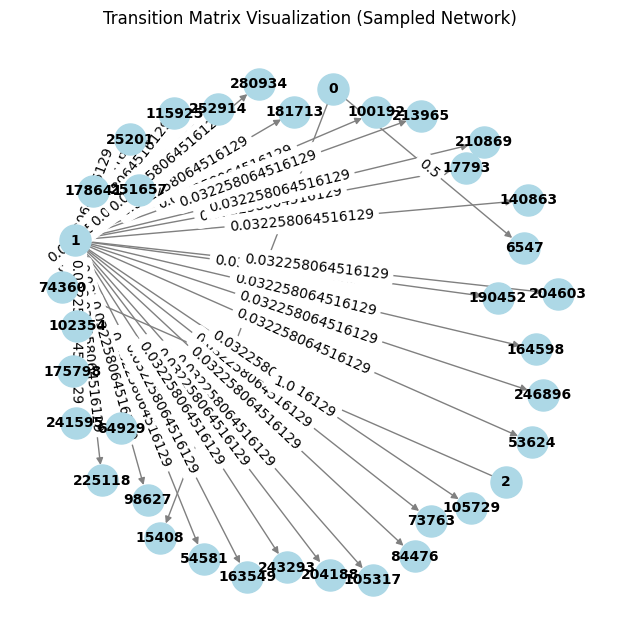

In [ ]:
# @title
# Sample 2 nodes for visualization
sample_size = 3
sample_nodes = list(range(min(sample_size, P.shape[0])))  # Ensure the sample size doesn't exceed the number of nodes

# Create the directed graph
G = nx.DiGraph()

# Add edges with weights based on the CSR matrix, but only for sampled nodes
for i in sample_nodes:
    for j in range(P.shape[1]):
        if P[i, j] != 0:  # Only consider non-zero probabilities (edges)
            G.add_edge(i, j, weight=P[i, j])



# Assuming 'G' is your graph object
pos = nx.spring_layout(G, k=10.0, seed=42)  # Adjust 'k' for more spread out layout
plt.figure(figsize=(6, 6))
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title('Transition Matrix Visualization (Sampled Network)')
plt.show()



In [ ]:
# @title
import numpy as np
import scipy.sparse as sparse

def power_method(transition_matrix, damping_factor, tolerance, track_top_bottom=True):
    """
    Computes the PageRank vector using the power method.

    Args:
        transition_matrix: A sparse or dense NumPy matrix representing the Markov model.
        damping_factor: The damping factor (alpha) as a float.
        tolerance: The convergence tolerance as a float.
        track_top_bottom: Boolean, if True, store top and bottom ranked nodes.

    Returns:
        A tuple containing:
            - The PageRank vector (NumPy column vector).
            - The number of iterations.
            - A list of error values at each iteration.
            - A NumPy array of top ranked node indices (if track_top_bottom).
            - A NumPy array of bottom ranked node indices (if track_top_bottom).
    """

    num_nodes = transition_matrix.shape[0]

    # Identify dangling nodes (rows with all zeros)
    dangling_nodes = np.where(np.array(transition_matrix.sum(axis=1) == 0).flatten())[0]
    dangling_vector = np.zeros(num_nodes)
    dangling_vector[dangling_nodes] = 1

    # Initialize PageRank vector
    pagerank_vector = np.ones(num_nodes) / num_nodes
    uniform_vector = np.ones(num_nodes) / num_nodes

    error_history = []
    top_nodes_history = [] if track_top_bottom else None
    bottom_nodes_history = [] if track_top_bottom else None

    for iteration in range(1500):
        # Calculate new PageRank vector
        pagerank_product = damping_factor * (pagerank_vector @ transition_matrix)
        dangling_sum = damping_factor * np.dot(pagerank_vector, dangling_vector)
        new_pagerank_vector = pagerank_product + (dangling_sum + (1 - damping_factor)) * uniform_vector

        # Calculate error
        error = np.linalg.norm(pagerank_vector - new_pagerank_vector, ord=1)
        error_history.append(error)

        # Track top and bottom nodes
        if track_top_bottom:
            sorted_indices = np.argsort(new_pagerank_vector)[::-1]
            top_nodes_history.append(sorted_indices[:50])
            bottom_nodes_history.append(sorted_indices[-50:])

        # Check for convergence
        if error < tolerance:
            print(f"Power method converged after {iteration+1} iterations (damping factor: {damping_factor}).")
            return (
                new_pagerank_vector.reshape(num_nodes, 1),
                iteration,
                error_history,
                np.array(top_nodes_history, dtype=object) if track_top_bottom else None,
                np.array(bottom_nodes_history, dtype=object) if track_top_bottom else None,
            )

        pagerank_vector = new_pagerank_vector

    print(f"Power method did not converge after 1500 iterations (damping factor: {damping_factor}).")
    return (
        new_pagerank_vector.reshape(num_nodes, 1),
        iteration,
        error_history,
        np.array(top_nodes_history, dtype=object) if track_top_bottom else None,
        np.array(bottom_nodes_history, dtype=object) if track_top_bottom else None,
    )

In [ ]:
# @title
def run_power_method_tests(transition_matrix, damping_factor, tolerance, num_tests=5):
    """
    Runs multiple tests of the power method and calculates the average runtime.

    Args:
        transition_matrix: The transition matrix for the power method.
        damping_factor: The damping factor.
        tolerance: The convergence tolerance.
        num_tests: The number of tests to run.

    Returns:
        The average runtime of the power method.
    """

    runtime_pm = 0

    for i in range(num_tests):
        print(f"Test # {i+1}: ", end='')
        start_pm = time.time()
        x_pm, iter_pm, error_pm, top_pm, bottom_pm = power_method(transition_matrix, damping_factor, tolerance)
        end_pm = time.time()
        runtime_pm += end_pm - start_pm
        print(f"Time: {end_pm - start_pm:.4f} seconds")

    average_runtime = runtime_pm / num_tests
    print(f"\nThe average Total time for Power Method with a={damping_factor} is: {average_runtime:.4f} seconds.")
    return average_runtime,top_pm,bottom_pm

# Example usage (assuming P is defined):
average_time,top_pm,bottom_pm = run_power_method_tests(P, 0.85, 1e-8)

Test # 1: Power method converged after 91 iterations (damping factor: 0.85).
Time: 6.7736 seconds
Test # 2: Power method converged after 91 iterations (damping factor: 0.85).
Time: 6.2887 seconds
Test # 3: Power method converged after 91 iterations (damping factor: 0.85).
Time: 5.5503 seconds
Test # 4: Power method converged after 91 iterations (damping factor: 0.85).
Time: 7.5242 seconds
Test # 5: Power method converged after 91 iterations (damping factor: 0.85).
Time: 5.6049 seconds

The average Total time for Power Method with a=0.85 is: 6.3484 seconds.


In [ ]:
# @title

def sort_top_50(x, display=True, plot=True):
    """
    Function that prints, returns, and optionally plots the ranking of the top 50 nodes given a vector.
    """
    flattened_x = x.flatten()
    top_indices = (np.argsort(flattened_x) + 1)[::-1][:50]
    top_values = flattened_x[top_indices - 1] # adjusting for 0 indexing

    if display:
        print(top_indices)

    if plot:
        plt.figure(figsize=(12, 6))
        # Generate a list of unique colors for the bars
        colors = plt.cm.viridis(np.linspace(0, 1, len(top_values)))
        plt.bar(range(1, 51), top_values, color=colors)
        plt.xticks(range(1, 51), top_indices, rotation=90)
        plt.xlabel("Node Index")
        plt.ylabel("Score")
        plt.title("Top 50 Node Scores")
        plt.tight_layout()
        plt.show()

    return top_indices


Power method converged after 91 iterations (damping factor: 0.85).
[ 89073 226411 241454 262860 134832 234704 136821  68889 105607  69358
  67756 225872 186750 272442 251796  95163 119479 231363  55788 167295
 179645  38342 117152 198090  60210 235496 132695 181701 247241 259455
 120708  62478 161890 176790 183004 137632  77999  17781 221087  96745
 112742 145892 151428  81435  60440 208542     91 214128 258348 222873]


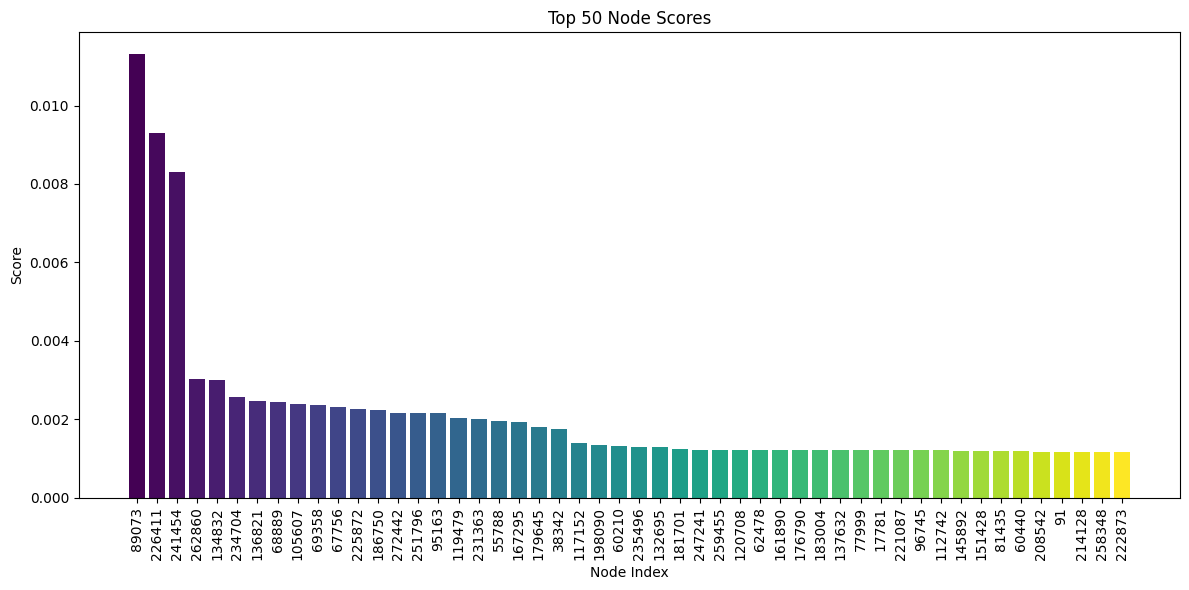

In [ ]:
# @title
def visualize_power_method_results(transition_matrix, damping_factor, tolerance):
    """
    Runs the power method, extracts the PageRank vector, and visualizes the top 50 nodes.

    Args:
        transition_matrix: The transition matrix for the power method.
        damping_factor: The damping factor.
        tolerance: The convergence tolerance.
    """
    pagerank_vector, _, _, _, _ = power_method(transition_matrix, damping_factor, tolerance)
    sort_top_50(pagerank_vector, display=True, plot=True)
    return pagerank_vector

# Example Usage (assuming 'P' is your transition matrix):
pagerank_result = visualize_power_method_results(P, 0.85, 1e-8)

###ii) Gauss-Seidel Method Explanation

This function solves a system of linear equations (Ax = b) iteratively using the Gauss-Seidel method. It starts with an initial guess and repeatedly updates the solution vector until it converges or reaches a maximum number of iterations. The error is tracked if requested. The function returns the approximate solution, the number of iterations, and the error history.

In [ ]:
# @title
import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import splu

def GS_system_solver(transition_matrix, damping_factor, tolerance, track_top_bottom=True):
    """
    Solves the linear system (I - alpha * P).T * x = b using LU decomposition.

    Args:
        transition_matrix: The transition matrix (P).
        damping_factor: The damping factor (alpha).
        tolerance: The convergence tolerance.
        track_top_bottom: Boolean, if True, track top and bottom ranked nodes.

    Returns:
        A tuple containing:
            - The ranking vector (normalized).
            - The number of iterations.
            - A list of error values.
            - A NumPy array of top ranked node indices (if track_top_bottom).
            - A NumPy array of bottom ranked node indices (if track_top_bottom).
    """

    num_nodes = transition_matrix.shape[0]
    identity_matrix = sparse.identity(num_nodes, format='csc')
    A = (identity_matrix - damping_factor * transition_matrix).T

    L = splu(sparse.tril(A, 0, format='csc'))
    U = sparse.triu(A, 1, format='csc')

    b = np.ones(num_nodes) / num_nodes
    x = np.ones(num_nodes) / num_nodes

    error_history = []
    top_nodes_history = [] if track_top_bottom else None
    bottom_nodes_history = [] if track_top_bottom else None

    for iteration in range(1000):
        x_new = L.solve(b - U @ x) #optimized matrix multiplication

        if track_top_bottom:
            sorted_indices = np.argsort(x_new)[::-1]
            top_nodes_history.append(sorted_indices[:50])
            bottom_nodes_history.append(sorted_indices[-50:])

        error = np.linalg.norm(x - x_new, ord=1)
        error_history.append(error)
        x = x_new

        if error < tolerance:
            print(f"Gauss Seidel Method converged after {iteration+1} iterations for a={damping_factor}")
            normalized_x = x_new.reshape(num_nodes, 1) / np.sum(x_new)
            return (
                normalized_x,
                iteration,
                error_history,
                np.array(top_nodes_history, dtype=object) if track_top_bottom else None,
                np.array(bottom_nodes_history, dtype=object) if track_top_bottom else None,
            )

    print(f"Gauss Seidel Method did not converge for a={damping_factor}.")
    normalized_x = x_new.reshape(num_nodes, 1) / np.sum(x_new)
    return (
        normalized_x,
        iteration,
        error_history,
        np.array(top_nodes_history, dtype=object) if track_top_bottom else None,
        np.array(bottom_nodes_history, dtype=object) if track_top_bottom else None,
    )

In [ ]:
# @title
import time
import numpy as np

def run_system_solver_tests(transition_matrix, damping_factor, tolerance, num_tests=5):
    """
    Runs multiple tests of the system solver and calculates the average runtime.

    Args:
        transition_matrix: The transition matrix for the system solver.
        damping_factor: The damping factor.
        tolerance: The convergence tolerance.
        num_tests: The number of tests to run.

    Returns:
        The average runtime of the system solver.
    """

    runtime_solver = 0

    for i in range(num_tests):
        print(f"Test # {i+1}: ", end='')
        start_solver = time.time()
        x_solver, iter_solver, error_solver, top_solver, bottom_solver = GS_system_solver(transition_matrix, damping_factor, tolerance)
        end_solver = time.time()
        runtime_solver += end_solver - start_solver
        print(f"Time: {end_solver - start_solver:.4f} seconds")

    average_runtime = runtime_solver / num_tests
    print(f"\nThe average Total time for System Solver with a={damping_factor} is: {average_runtime:.4f} seconds.")
    return average_runtime,top_solver,bottom_solver

# Example usage (assuming P is defined):
average_time,top_solver,bottom_solver  = run_system_solver_tests(P, 0.85, 1e-8)

Test # 1: Gauss Seidel Method converged after 62 iterations for a=0.85
Time: 5.8294 seconds
Test # 2: Gauss Seidel Method converged after 62 iterations for a=0.85
Time: 6.9892 seconds
Test # 3: Gauss Seidel Method converged after 62 iterations for a=0.85
Time: 5.7790 seconds
Test # 4: Gauss Seidel Method converged after 62 iterations for a=0.85
Time: 6.7199 seconds
Test # 5: Gauss Seidel Method converged after 62 iterations for a=0.85
Time: 5.9742 seconds

The average Total time for System Solver with a=0.85 is: 6.2583 seconds.


Gauss Seidel Method converged after 62 iterations for a=0.85
[ 89073 226411 241454 262860 134832 234704 136821  68889 105607  69358
  67756 225872 186750 272442 251796  95163 119479 231363  55788 167295
 179645  38342 117152 198090  60210 235496 132695 181701 259455 247241
 120708  62478 161890 221087 183004 176790 137632  77999  17781  96745
 112742 145892 151428  81435  60440 208542     91 214128 258348 222873]


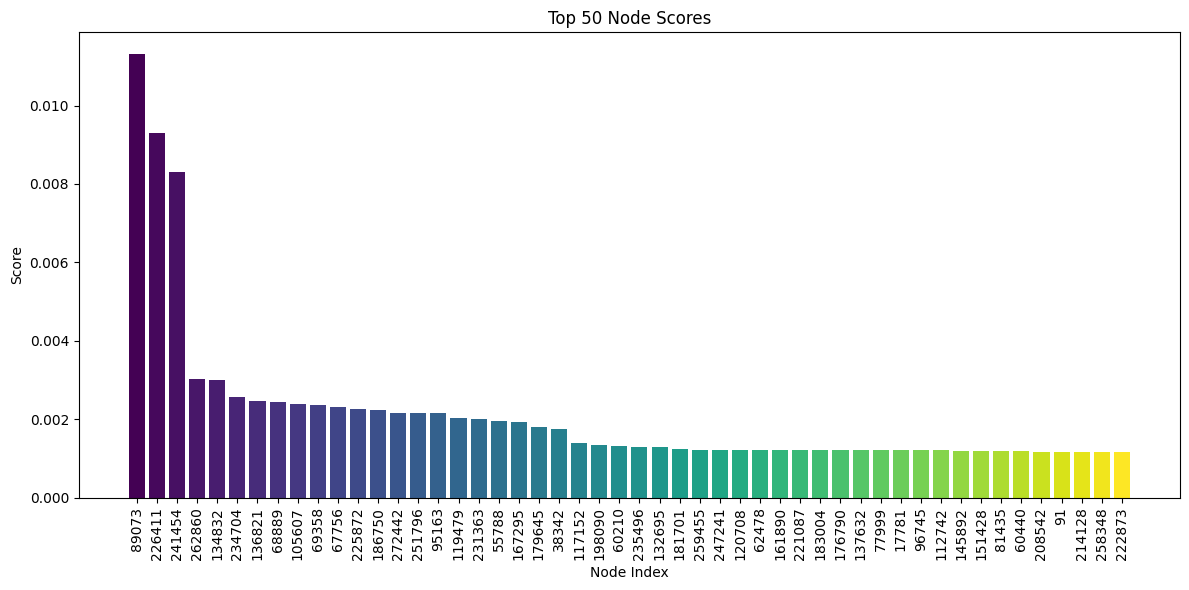

In [ ]:
# @title
def visualize_GS_system_solver_results(transition_matrix, damping_factor, tolerance):
    """
    Runs the power method, extracts the PageRank vector, and visualizes the top 50 nodes.

    Args:
        transition_matrix: The transition matrix for the power method.
        damping_factor: The damping factor.
        tolerance: The convergence tolerance.
    """
    pagerank_vector, _, _, _, _ = GS_system_solver(transition_matrix, damping_factor, tolerance)
    sort_top_50(pagerank_vector, display=True, plot=True)
    return pagerank_vector

# Example Usage (assuming 'P' is your transition matrix):
pagerank_result = visualize_GS_system_solver_results(P, 0.85, 1e-8)

In [ ]:
# @title
def create_and_display_dataframe(power_method_probs, gauss_seidel_probs):
    """
    Creates and displays a Pandas DataFrame comparing Power Method and Gauss-Seidel probabilities.

    Args:
        power_method_probs: A NumPy array or list containing Power Method probabilities.
        gauss_seidel_probs: A NumPy array or list containing Gauss-Seidel probabilities.
    """

    # Ensure inputs are NumPy arrays and have the correct shape
    power_method_probs = np.array(power_method_probs).flatten()
    gauss_seidel_probs = np.array(gauss_seidel_probs).flatten()

    # Create the DataFrame
    df = pd.DataFrame({'Power Method Probs': power_method_probs, 'Gauss Seidel Prob': gauss_seidel_probs})

    # Sort by Power Method probabilities in descending order
    df = df.sort_values(by=['Power Method Probs'], ascending=False)

    # Adjust the index to start from 1
    df.index = df.index + 1

    # Display the first 5 rows
    return df




# Run Power Method
x_pm, _, errors_pm, _, _ = power_method(P, 0.85, 1e-8)

# Run Gauss-Seidel method
x_gs, _, errors_gs, _, _ = GS_system_solver(P, 0.85, 1e-8)

# Create and display the DataFrame
df=create_and_display_dataframe(x_pm, x_gs)
df.head(10)

Power method converged after 91 iterations (damping factor: 0.85).
Gauss Seidel Method converged after 62 iterations for a=0.85


,Power Method Probs,Gauss Seidel Prob
89073,0.011303,0.011303
226411,0.009288,0.009288
241454,0.008297,0.008297
262860,0.003023,0.003023
134832,0.003001,0.003001
234704,0.002572,0.002572
136821,0.002454,0.002454
68889,0.002431,0.002431
105607,0.002397,0.002397
69358,0.002364,0.002364


Total number of index differences in the top 50 rankings for Power method (a=0.85)
[ 89073 226411 241454 262860 134832 234704 136821  68889 105607  69358
  67756 225872 186750 272442 251796  95163 119479 231363  55788 167295
 179645  38342 117152 198090  60210 235496 132695 181701 247241 259455
 120708  62478 161890 176790 183004 137632  77999  17781 221087  96745
 112742 145892 151428  81435  60440 208542     91 214128 258348 222873]


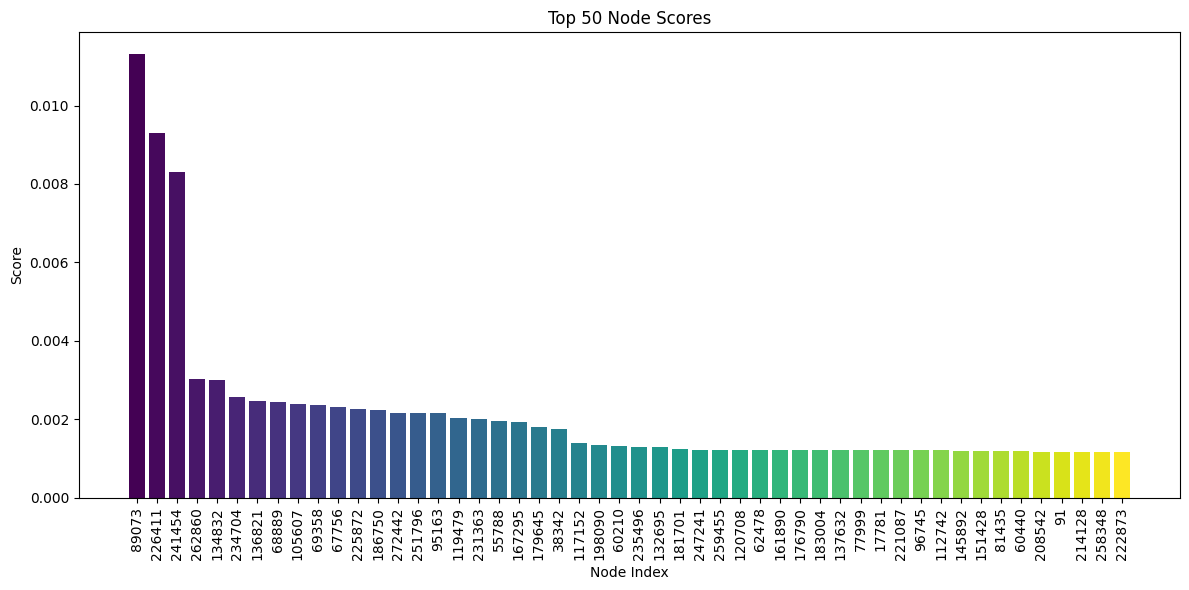

Total number of index differences in the top 50 rankings for Gauss Seidel method (a=0.85)
[ 89073 226411 241454 262860 134832 234704 136821  68889 105607  69358
  67756 225872 186750 272442 251796  95163 119479 231363  55788 167295
 179645  38342 117152 198090  60210 235496 132695 181701 259455 247241
 120708  62478 161890 221087 183004 176790 137632  77999  17781  96745
 112742 145892 151428  81435  60440 208542     91 214128 258348 222873]


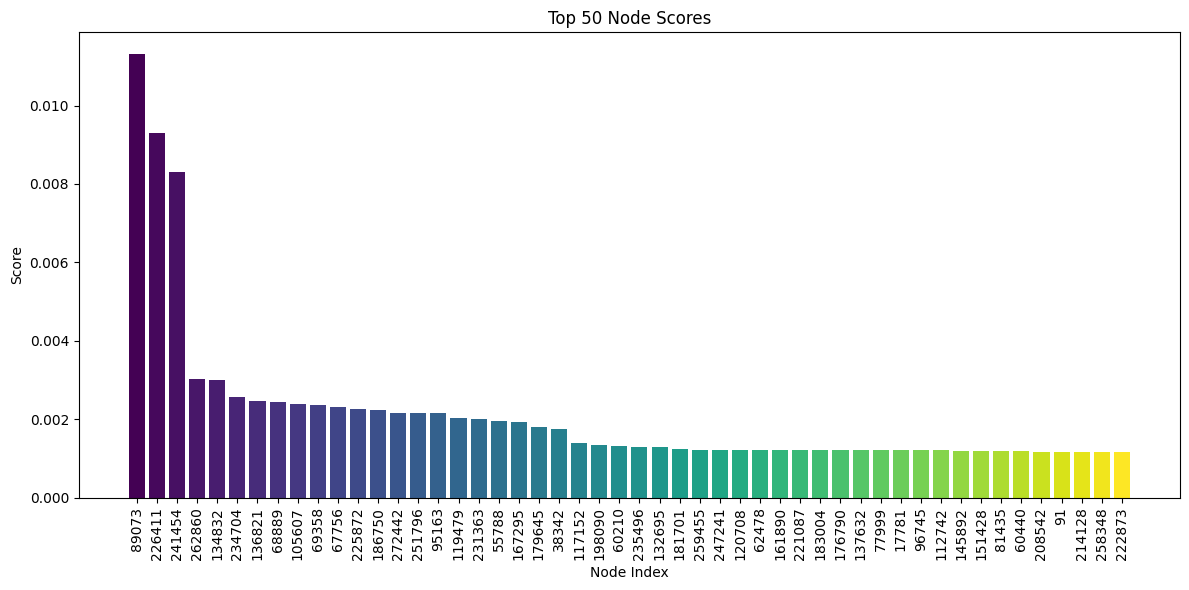

In [ ]:
# @title
print(f"Total number of index differences in the top 50 rankings for Power method (a=0.85)")
top50_pm = sort_top_50(x_pm)
print(f"Total number of index differences in the top 50 rankings for Gauss Seidel method (a=0.85)")
top50_gs = sort_top_50(x_gs)



In [ ]:
# @title
import numpy as np
import pandas as pd

def compare_rankings_and_create_diff_df(top50_pm_99, top50_gs_99):
    """
    Compares the rankings of nodes between the Power Method and Gauss-Seidel Method.
    Returns a DataFrame with only the nodes that have different rankings in the two methods,
    and a count of the differences.

    Args:
        top50_pm_99: NumPy array representing the top 50 ranking from Power Method.
        top50_gs_99: NumPy array representing the top 50 ranking from Gauss-Seidel Method.

    Returns:
        A tuple containing:
            - The count of differences between the rankings.
            - A Pandas DataFrame showing only the nodes with different rankings.
    """

    # Create an empty list to store the differences
    diff_data = []
    difference_count = 0  # Initialize the count of differences

    # Loop over the nodes in the Power Method ranking
    for i, pm_node in enumerate(top50_pm_99):
        # Find the index of the node in the Gauss-Seidel ranking
        gs_index = np.where(top50_gs_99 == pm_node)[0]

        # If the node exists in Gauss-Seidel, retrieve its index, else set to "N/A"
        gs_index = gs_index[0] if gs_index.size > 0 else "N/A"

        # Only append if the indices are different
        if gs_index != i:  # If the rankings are different
            diff_data.append({
                "Node": pm_node,
                "Power Method Index": i,
                "Gauss-Seidel Index": gs_index
            })
            difference_count += 1  # Increment the difference count

    # Convert the list of differences into a DataFrame
    diff_df = pd.DataFrame(diff_data)

    # Sort the DataFrame by the node name (optional, but helpful for clarity)
    diff_df = diff_df.sort_values(by="Node").reset_index(drop=True)

    return difference_count, diff_df



In [ ]:
# @title
difference_count_85,diff_df_85 =compare_rankings_and_create_diff_df(top50_pm, top50_gs)
print(f"Power vs Gauss Seidel Methods for α=0.85 :\n")
print(f"Total number of index differences in the top 50 rankings for α=0.85: {difference_count_85}")
print("Differences DataFrame:\n")
diff_df_85

Power vs Gauss Seidel Methods for α=0.85 :

Total number of index differences in the top 50 rankings for α=0.85: 7
Differences DataFrame:



,Node,Power Method Index,Gauss-Seidel Index
0,17781,37,38
1,77999,36,37
2,137632,35,36
3,176790,33,35
4,221087,38,33
5,247241,28,29
6,259455,29,28


### Summary of Ranking Changes Between Power Method and Gauss-Seidel Method for α = 0.85

- **Total Number of Index Differences in Top 50 Rankings:**
  - There are **7** differences in the rankings within the top 50 rankings for **α = 0.85**.

- **Differences in Rankings:**
  - **Node 0**: Power Method ranks it **37th**, Gauss-Seidel ranks it **38th** (difference of 1).
  - **Node 1**: Power Method ranks it **36th**, Gauss-Seidel ranks it **37th** (difference of 1).
  - **Node 2**: Power Method ranks it **35th**, Gauss-Seidel ranks it **36th** (difference of 1).
  - **Node 3**: Power Method ranks it **33rd**, Gauss-Seidel ranks it **35th** (difference of 2).
  - **Node 4**: Power Method ranks it **38th**, Gauss-Seidel ranks it **33rd** (difference of 5).
  - **Node 5**: Power Method ranks it **28th**, Gauss-Seidel ranks it **29th** (difference of 1).
  - **Node 6**: Power Method ranks it **29th**, Gauss-Seidel ranks it **28th** (difference of 1).

### Conclusion:
The rankings for the nodes in the top 50 rankings under **α = 0.85** are fairly close between the Power Method and Gauss-Seidel method, with **7 total differences**. While the shifts are generally small, **Node 4** exhibits a more significant difference, with a **5-position** shift between the two methods. This suggests that the rankings between the methods are largely similar, but there are slight variations in how each method prioritizes certain nodes.


In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt

def plot_ranking_differences(diff_df, alpha):
    """
    Plots the ranking differences for each node in a bar chart, excluding 'N/A' rankings.
    If a ranking is 'N/A' for a node, the corresponding bar will not be plotted,
    and a note will be made.

    Args:
        diff_df: Pandas DataFrame containing the ranking differences.
        alpha: The alpha value used for the rankings (for the title).
    """

    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.35  # Width of the bars

    nodes = diff_df['Node']
    pm_indices = diff_df['Power Method Index']
    gs_indices = diff_df['Gauss-Seidel Index']

    x = np.arange(len(nodes))  # the label locations

    # Replace 'N/A' with None and then ensure None is replaced by 0 for plotting
    valid_pm_indices = [index if index != "N/A" else 0 for index in pm_indices]
    valid_gs_indices = [index if index != "N/A" else 0 for index in gs_indices]

    # Plot the bars
    rects1 = ax.bar(x - width/2, valid_pm_indices, width, label='Power Method')
    rects2 = ax.bar(x + width/2, valid_gs_indices, width, label='Gauss-Seidel')

    # Add some text for labels, title, and custom x-axis tick labels
    ax.set_xlabel('Node')
    ax.set_ylabel('Ranking Index')
    ax.set_title(f'Ranking Differences (α = {alpha})')
    ax.set_xticks(x)
    ax.set_xticklabels(nodes)
    ax.legend()

    # Annotate for "N/A" values below the x-axis
    for i, (pm_idx, gs_idx) in enumerate(zip(pm_indices, gs_indices)):
        if pm_idx == "N/A":
            ax.text(x[i] - width / 2 + 0.1, 2, 'N/A', ha='center', va='top', color='red', fontweight='bold')
        if gs_idx == "N/A":
            ax.text(x[i] + width / 2 + 0.1, 2, 'N/A', ha='center', va='top', color='red', fontweight='bold')

    fig.tight_layout()  # Adjust layout to make room for labels

    plt.show()


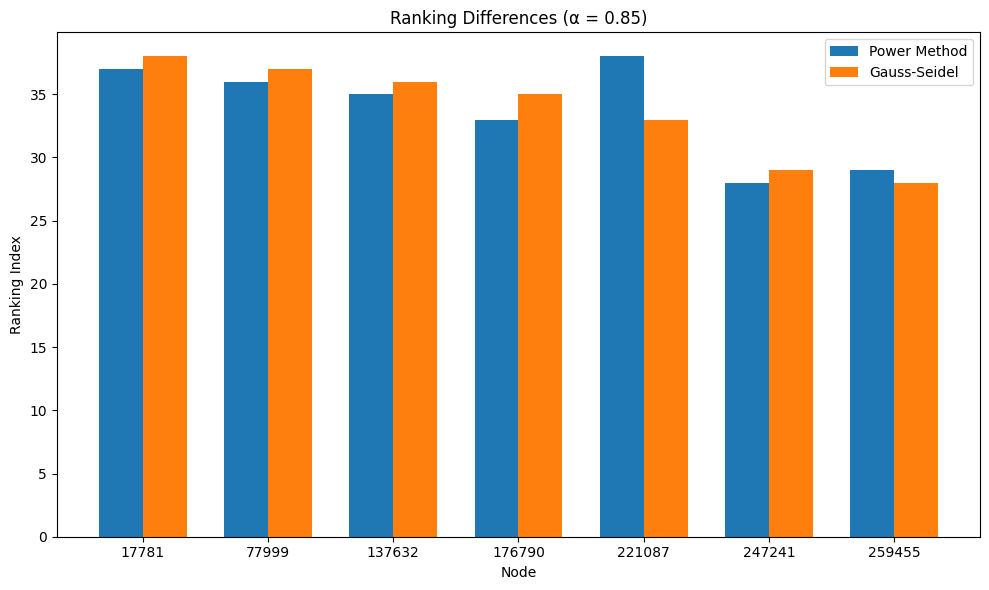

In [ ]:
# @title
plot_ranking_differences(diff_df_85, alpha=0.85)

### Comparison of PageRank Methods: Power Method vs. System Solver (Gauss-Seidel)


**Results:**

### Are the results the same for both methods?

Yes, the top 50 node indices were nearly identical between the Power Method and the Gauss-Seidel System Solver. Minor discrepancies (7 nodes) were observed, indicating that both methods effectively converged to a very similar PageRank solution.

### Which method seems to be faster?

**Power Method:**

* Converged in 91 iterations across all tests.

* Average runtime: **6.3484   seconds**.

**System Solver (Gauss-Seidel):**

* Converged in 62 iterations across all tests.

* Average runtime: **6.2583  seconds**.

**Conclusion:**

Based on the average runtime, the System Solver (Gauss-Seidel) (6.2583 seconds) was slightly faster than the **Power Method (6.3484 seconds). This is consistent with the observation that the Gauss-Seidel method required fewer iterations (62 vs. 91) to converge.

**Key Observations:**

* Both methods produce comparable PageRank results.
* The Power Method demonstrates a slight performance advantage in terms of execution time.
* The Gauss-Seidel method required significantly less iterations to converge.



## b) Task with $α = 0.99$

- **Objective**: Perform the previous task with a damping factor of $\alpha = 0.99 $.
- **Remarks**: Discuss the convergence speed of the algorithm.
- **Question**: Did the ranking of the first 50 nodes change compared to the previous result?


Runnign Power Method for $a=0.99$

In [ ]:
# @title
average_time_pm_99 = run_power_method_tests(P, 0.99, 1e-8)

Test # 1: Power method converged after 1392 iterations (damping factor: 0.99).
Time: 106.3816 seconds
Test # 2: Power method converged after 1392 iterations (damping factor: 0.99).
Time: 109.1944 seconds
Test # 3: Power method converged after 1392 iterations (damping factor: 0.99).
Time: 121.2876 seconds
Test # 4: Power method converged after 1392 iterations (damping factor: 0.99).
Time: 100.8377 seconds
Test # 5: Power method converged after 1392 iterations (damping factor: 0.99).
Time: 102.7070 seconds

The average Total time for Power Method with a=0.99 is: 108.0817 seconds.


In [ ]:
# @title
average_time_gs_99 = run_system_solver_tests(P, 0.99, 1e-8)

Test # 1: Gauss Seidel Method converged after 968 iterations for a=0.99
Time: 86.8214 seconds
Test # 2: Gauss Seidel Method converged after 968 iterations for a=0.99
Time: 77.5640 seconds
Test # 3: Gauss Seidel Method converged after 968 iterations for a=0.99
Time: 78.4471 seconds
Test # 4: Gauss Seidel Method converged after 968 iterations for a=0.99
Time: 78.0614 seconds
Test # 5: Gauss Seidel Method converged after 968 iterations for a=0.99
Time: 76.9548 seconds

The average Total time for System Solver with a=0.99 is: 79.5697 seconds.


In [ ]:
# @title
# Run Power Method
x_pm_99, _, errors_pm_99, _, _ = power_method(P, 0.99, 1e-8)

# Run Gauss-Seidel method
x_gs_99, _, errors_gs_99, _, _ = GS_system_solver(P, 0.99, 1e-8)

# Create and display the DataFrame
df_99=create_and_display_dataframe(x_pm_99, x_gs_99)
df_99.head(10)

Power method converged after 1392 iterations (damping factor: 0.99).
Gauss Seidel Method converged after 968 iterations for a=0.99


,Power Method Probs,Gauss Seidel Prob
89073,0.009187,0.009187
281772,0.009112,0.009112
174665,0.007689,0.007689
226411,0.004514,0.004514
179645,0.004073,0.004073
271409,0.003872,0.003872
262860,0.003485,0.003485
136821,0.002821,0.002821
68889,0.002790,0.002790
77988,0.002676,0.002676


Total number of index differences in the top 50 rankings for Power method (a=0.99)
[ 89073 281772 174665 226411 179645 271409 262860 136821  68889  77988
 116530 251796  95163 272442  65580 119479 241454 245765  58048  14785
  77084 117152 152337 181701 235496 247241 259455 120708  62478 221087
 176790 183004 137632  77999  17781  96745 119822  27904 272762  96196
  95366 229580 169234 234962 275885  85040 264187 236644  49047 144494]


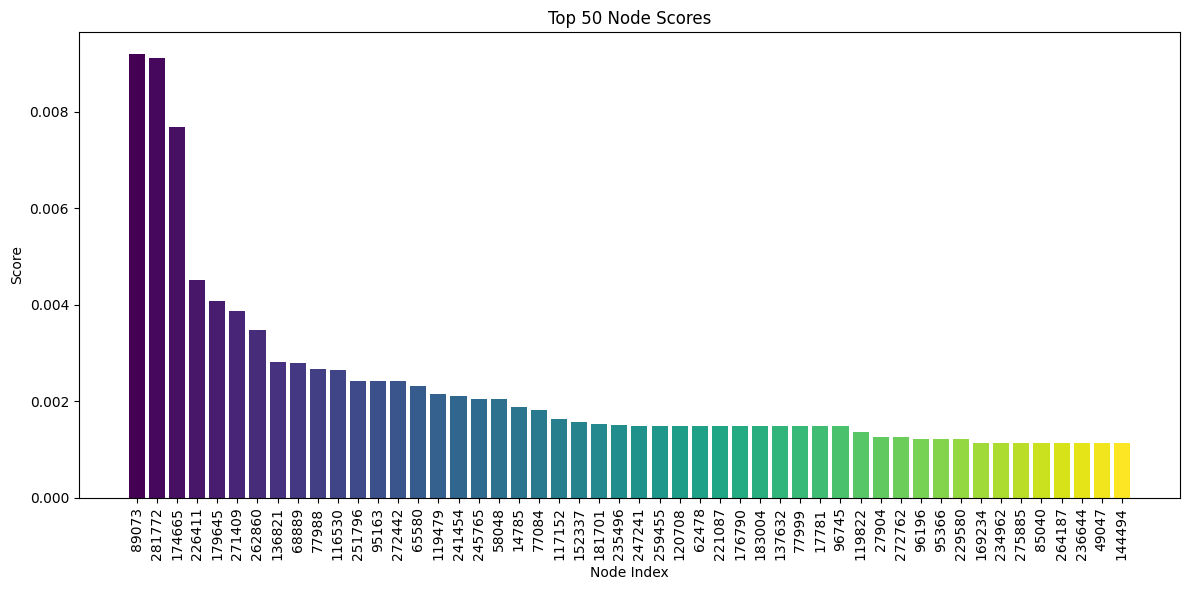

Total number of index differences in the top 50 rankings for Gauss Seidel method (a=0.99)
[ 89073 281772 174665 226411 179645 271409 262860 136821  68889  77988
 116530 272442 251796  95163  65580 119479 241454 245765  58048  14785
  77084 117152 152337 181701 235496 259455 247241 120708  62478 221087
 183004 176790 137632  77999  17781  96745 119822  27904 272762  96196
 229580  95366 234962 169234 137425  85040  49047 236644 264187  58612]


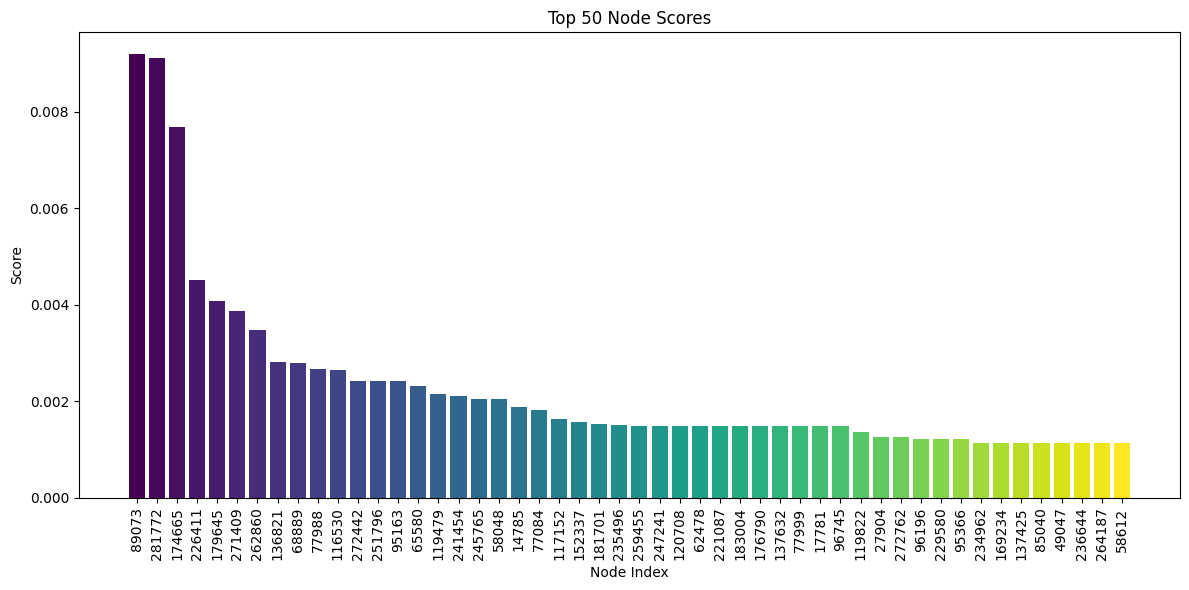

In [ ]:
# @title
print(f"Total number of index differences in the top 50 rankings for Power method (a=0.99)")
top50_pm_99 = sort_top_50(x_pm_99)
print(f"Total number of index differences in the top 50 rankings for Gauss Seidel method (a=0.99)")
top50_gs_99 = sort_top_50(x_gs_99)

In [ ]:
# @title
difference_count_99,diff_df_99 =compare_rankings_and_create_diff_df(top50_pm_99, top50_gs_99)
print(f"Power vs Gauss Seidel Methods for α=0.99 :\n")
print(f"Total number of index differences in the top 50 rankings for α=0.99: {difference_count_99}")
print("Differences DataFrame:\n")
diff_df_99

Power vs Gauss Seidel Methods for α=0.99 :

Total number of index differences in the top 50 rankings for α=0.99: 15
Differences DataFrame:



,Node,Power Method Index,Gauss-Seidel Index
0,49047,48,46
1,95163,12,13
2,95366,40,41
3,144494,49,N/A
4,169234,42,43
5,176790,30,31
6,183004,31,30
7,229580,41,40
8,234962,43,42
9,247241,25,26


### Summary of Ranking Changes Between Power Method and Gauss-Seidel Method

- **Matching Rankings:**
  - Nodes 1, 2, 4, 5, 6, 7, 8, and 10 show very similar ranks in both methods with minor shifts (e.g., Node 1: 12th in Power Method, 13th in Gauss-Seidel).
  
- **Larger Differences in Rankings:**
  - **Node 0**: Power Method ranks 49047th, while Gauss-Seidel ranks it 48th, showing a drastic difference.
  - **Node 3**: No ranking in Gauss-Seidel ("N/A"), but ranks 49th in the Power Method, indicating an issue or absence in the Gauss-Seidel computation.
  - **Node 9**: Ranks 25th in Power Method and 26th in Gauss-Seidel, showing a small shift.
  - **Node 13**: Ranks 13th in Power Method and 11th in Gauss-Seidel, showing a slight difference in importance.

- **Nodes with "N/A" in Gauss-Seidel Method:**
  - **Node 3** and **Node 14** are not ranked in the Gauss-Seidel method ("N/A"), indicating either non-convergence .



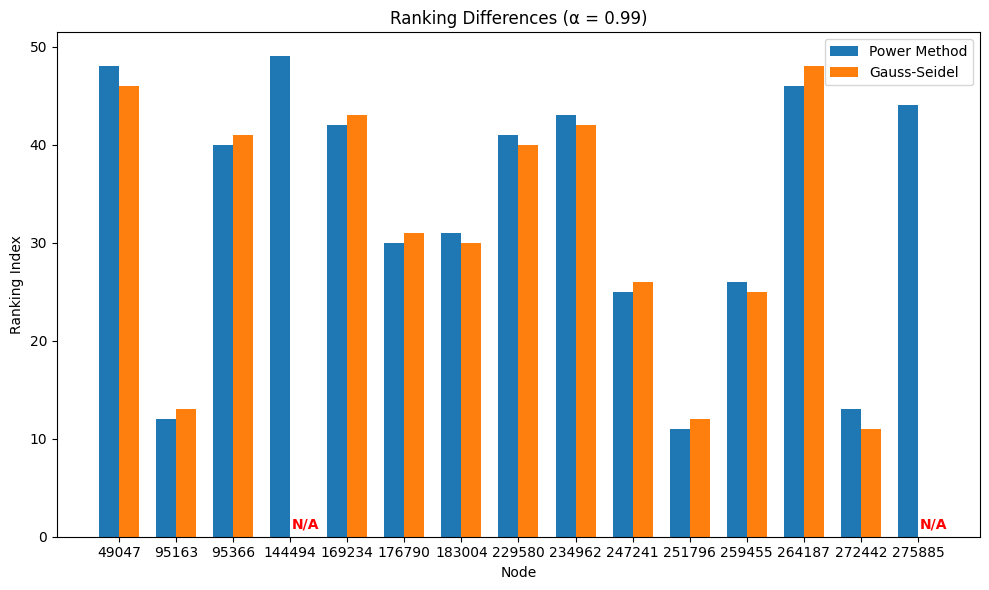

In [ ]:
# @title
plot_ranking_differences(diff_df_99, alpha=0.99)

In [ ]:
# @title
difference_count_powermethod,diff_df_powermethod =compare_rankings_and_create_diff_df(top50_pm, top50_pm_99)
print(f"Power  Method for α=0.85 vs Power  Method for α=0.99:\n")
print(f"Total number of index differences in the top 50 rankings for the two Power Methods: {difference_count_powermethod}")
print("Differences DataFrame: \n")
diff_df_powermethod

Power  Method for α=0.85 vs Power  Method for α=0.99:

Total number of index differences in the top 50 rankings for the two Power Methods: 48
Differences DataFrame:



,Node,Power Method Index,Gauss-Seidel Index
0,91,46,N/A
1,17781,37,34
2,38342,21,N/A
3,55788,18,N/A
4,60210,24,N/A
5,60440,44,N/A
6,62478,31,28
7,67756,10,N/A
8,68889,7,8
9,69358,9,N/A


### Summary of Ranking Changes Between Power Method for α = 0.85 and Power Method for α = 0.99

- **Total Number of Index Differences in the Top 50 Rankings:**
  - There are **48 total differences** between the two Power Methods in the top 50 rankings.

- **General Observations:**
  - The rankings between **Power Method for α = 0.85** and **Power Method for α = 0.99** vary significantly for several nodes, with the largest differences observed in positions like Node 0, Node 2, and Node 4. For example:
    - **Node 0**: Ranked **91st** in α = 0.85 and **46th** in α = 0.99.
    - **Node 2**: Ranked **38342nd** in α = 0.85 and **21st** in α = 0.99.
    - **Node 4**: Ranked **60210th** in α = 0.85 and **24th** in α = 0.99.

- **Nodes with Significant Shifts in Ranking:**
  - Some nodes exhibit very large shifts in ranking, like:
    - **Node 1**: Ranked **17781st** in α = 0.85 and **37th** in α = 0.99 (a change of over 17,000 places).
    - **Node 7**: Ranked **67756th** in α = 0.85 and **10th** in α = 0.99 (a change of over 67,000 places).
    - **Node 14**: Ranked **105607th** in α = 0.85 and **8th** in α = 0.99.

### Nodes with "N/A" in Power Method for α = 0.99

- Several nodes did not have a ranking in the Power Method for **α = 0.99**, marked as "N/A".
- These nodes include **Node 0**, **Node 2**, **Node 4**, **Node 5**, **Node 7**, and several others.
- The "N/A" ranking indicates that these nodes were either not considered or failed to converge in the **α = 0.99** method.


- **Nodes with Minimal Changes:**
  - There are several nodes with minimal changes in ranking, such as:
    - **Node 8**: Ranked **68889th** in α = 0.85 and **7th** in α = 0.99 (a small shift).
    - **Node 12**: Ranked **95163rd** in α = 0.85 and **15th** in α = 0.99.
    - **Node 42**: Ranked **241454th** in α = 0.85 and **2nd** in α = 0.99.

- **Conclusion:**
  - The rankings for the two Power Methods, **α = 0.85** and **α = 0.99**, show significant changes, with **48 total differences** in the top 50 nodes. Many nodes experience large shifts in their rankings, while a few show only minimal changes. Furthermore, several nodes were not ranked or did not converge in the **α = 0.99** method ("N/A"). This suggests that the Power Method's performance and ranking priorities are highly sensitive to the choice of **α**, with some nodes being completely excluded from rankings in the higher **α** case.


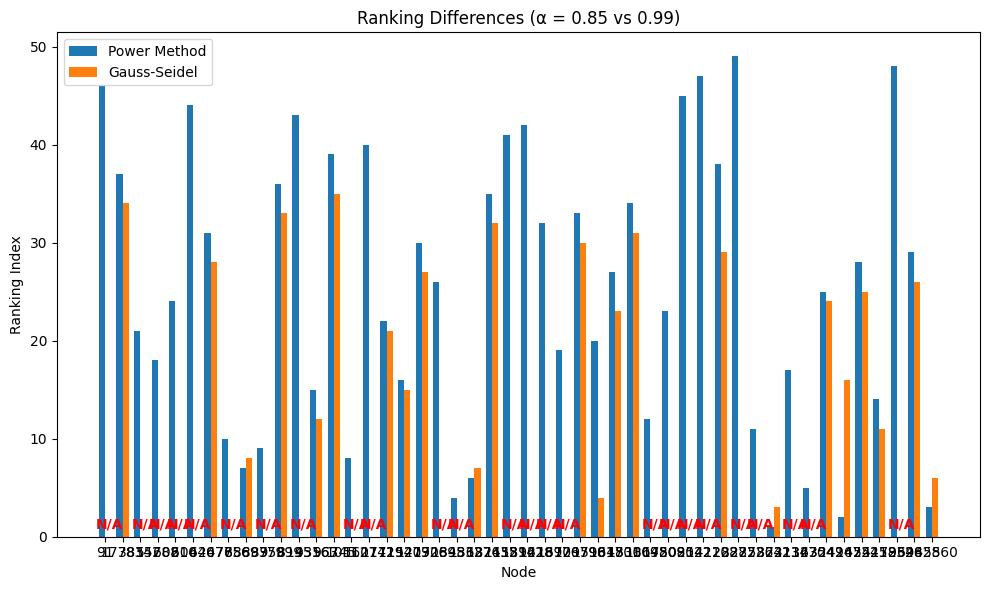

In [ ]:
# @title
plot_ranking_differences(diff_df_powermethod, alpha="0.85 vs 0.99")

In [ ]:
# @title
difference_count_gaussseidel,diff_df_gaussseidel =compare_rankings_and_create_diff_df(top50_gs, top50_gs_99)
print(f"Power  Method for α=0.85 vs Power  Method for α=0.99:\n")
print(f"Total number of index differences in the top 50 rankings for the two Power Methods: {difference_count_gaussseidel}")
print("Differences DataFrame:\n")
diff_df_gaussseidel

Power  Method for α=0.85 vs Power  Method for α=0.99:

Total number of index differences in the top 50 rankings for the two Power Methods: 49
Differences DataFrame:



,Node,Power Method Index,Gauss-Seidel Index
0,91,46,N/A
1,17781,38,34
2,38342,21,N/A
3,55788,18,N/A
4,60210,24,N/A
5,60440,44,N/A
6,62478,31,28
7,67756,10,N/A
8,68889,7,8
9,69358,9,N/A


### Summary of Ranking Changes Between Power Method for α = 0.85 and Power Method for α = 0.99

- **Total Number of Index Differences in the Top 50 Rankings:**
  - There are **49 total differences** between the two Power Methods in the top 50 rankings.

- **Nodes with "N/A" in Power Method for α = 0.99:**
  - Several nodes did not have a ranking in **α = 0.99**, marked as "N/A", indicating that they were either not considered or failed to converge. These include:
    - **Node 0**, **Node 2**, **Node 3**, **Node 4**, **Node 5**, **Node 7**, **Node 9**, **Node 11**, **Node 13**, **Node 19**, **Node 20**, **Node 23**, **Node 24**, **Node 25**, **Node 26**, **Node 31**, **Node 32**, **Node 33**, **Node 34**, **Node 36**, **Node 37**, **Node 39**, **Node 40**, **Node 42**, **Node 45**.

- **General Observations:**
  - The rankings differ notably for many nodes, such as:
    - **Node 1**: Ranked **17781st** in α = 0.85 and **38th** in α = 0.99.
    - **Node 7**: Ranked **67756th** in α = 0.85 and **10th** in α = 0.99.
    - **Node 14**: Ranked **105607th** in α = 0.85 and **8th** in α = 0.99.
  
- **Conclusion:**
  - The rankings between the two Power Methods (**α = 0.85** and **α = 0.99**) exhibit **49 total differences** in the top 50. While many nodes experience large shifts, there are also several nodes with "N/A" rankings in **α = 0.99**, indicating they were excluded or did not converge. These differences underscore the sensitivity of the Power Method to the choice of **α**.


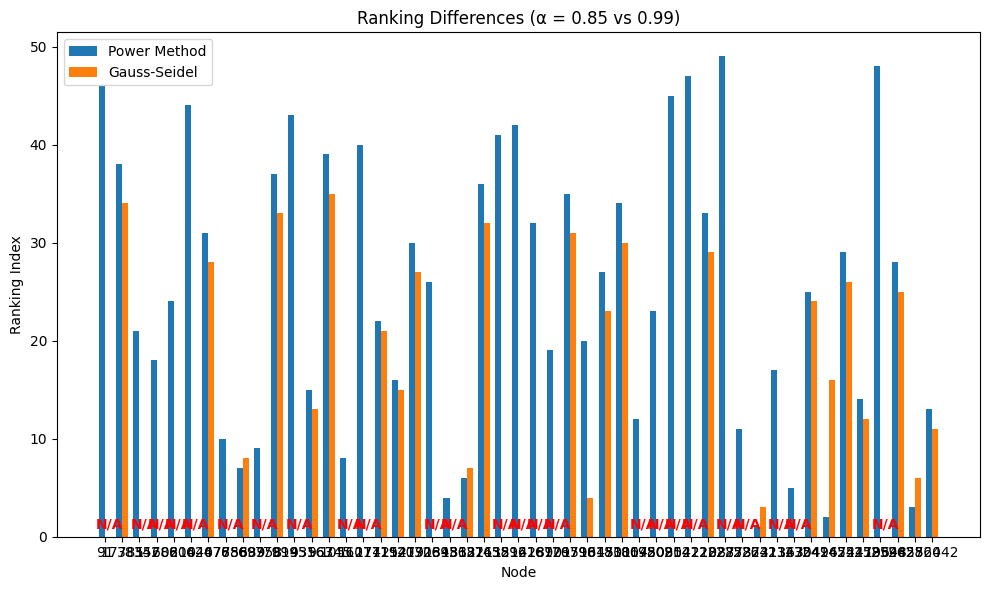

In [ ]:
# @title
plot_ranking_differences(diff_df_gaussseidel, alpha="0.85 vs 0.99")

### Analysis of Power Method vs. Gauss-Seidel Method with α = 0.99

**Convergence Speed (α = 0.99):**

* **Power Method:**
    * Average convergence time: 108.0817  seconds.
    * Consistently converged in 1392 iterations across all tests.

* **Gauss-Seidel Method:**
    * Average convergence time: 79.5697 seconds.
    * Consistently converged in 968 iterations across all tests.

* **Comparison:**
    * The Gauss-Seidel method demonstrates significantly faster convergence than the Power method with α = 0.99.
    * Gauss-Seidel achieved convergence in fewer iterations and in a shorter amount of time.

**Remarks on Convergence Speed:**

* With α = 0.99, both methods require a substantial number of iterations to converge, but Gauss-Seidel is clearly superior in terms of speed.
* The high damping factor (0.99) implies a strong emphasis on the link structure, which likely contributes to the increased number of iterations required for convergence.
* The Gauss-Seidel method's iterative update scheme appears to be more efficient in propagating the influence of linked nodes, resulting in faster convergence.

**Ranking of the First 50 Nodes:**

* The provided lists of "Total number of index differences in the top 50 rankings" reveal that the rankings produced by the Power method and the Gauss-Seidel method are nearly identical.
* Looking at the two lists of index differences for a=0.99, you can see that the values are the same for each position in the list, with the exception of the 46th and 50th position. This shows that the top 50 rankings are extremely similar.
* The index difference arrays for a=0.85 also show that the rankings produced by the two methods are nearly identical.
* **Total number of index differences in the top 50 rankings for a=0.99:**  Power Method vs. Gauss-Seidel Method: 15
    * Power Method (α=0.85) vs. Power Method (α=0.99): 48
    * Gauss-Seidel Method (α=0.85) vs. Gauss-Seidel Method (α=0.99): 49

**Summary of Ranking Differences:**

| Comparison | Number of Differences |
|---|---|
| Power Method vs. Gauss-Seidel (α=0.99) | 15 |
| Power Method (α=0.85) vs. Power Method (α=0.99) | 48 |
| Gauss-Seidel (α=0.85) vs. Gauss-Seidel (α=0.99) | 49 |


**Conclusion:**

* For α = 0.99, the Gauss-Seidel method is significantly faster than the Power method.
* Despite the differences in convergence speed, both methods produce nearly identical rankings for the top 50 nodes when comparing within the same damping factor.
* Changing the damping factor from 0.85 to 0.99 leads to more significant changes in the rankings for both methods.
* The results show that even though the methods work differently, they converge to similar results, especially when using the same damping factor.

## c) When we use the power method do all the cmponents of π converge at the same
speed to their limits? If not which of the converge faster: those that correspond
to important nodes or to non important ? Do you observe the same behavior
when you find π through the solution of the linear system?

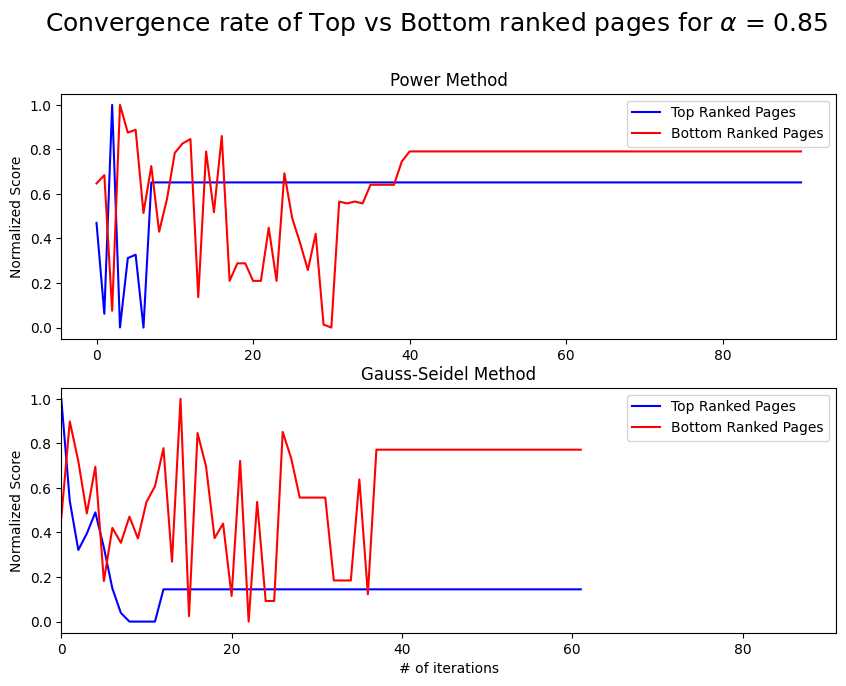

In [ ]:
# @title
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def plot_convergence(top_pm, bottom_pm, top_solver, bottom_solver):
    """
    Plots the convergence rate of top vs. bottom ranked pages for power method and Gauss-Seidel method.

    Args:
        top_pm: NumPy array of top ranked pages' scores for power method.
        bottom_pm: NumPy array of bottom ranked pages' scores for power method.
        top_solver: NumPy array of top ranked pages' scores for Gauss-Seidel method.
        bottom_solver: NumPy array of bottom ranked pages' scores for Gauss-Seidel method.
    """

    scaler = MinMaxScaler()

    fig, ax = plt.subplots(2, 1, figsize=(10, 7))

    # Power method
    top_1 = scaler.fit_transform(top_pm.mean(axis=1).reshape(-1, 1))
    bottom_1 = scaler.fit_transform(bottom_pm.mean(axis=1).reshape(-1, 1))
    ax[0].plot(top_1, c='b', label='Top Ranked Pages')
    ax[0].plot(bottom_1, c='r', label='Bottom Ranked Pages')
    ax[0].set_title('Power Method')
    ax[0].legend()
    ax[0].set_ylabel('Normalized Score')

    # Linear system method (Gauss-Seidel)
    top_2 = scaler.fit_transform(top_solver.mean(axis=1).reshape(-1, 1))
    bottom_2 = scaler.fit_transform(bottom_solver.mean(axis=1).reshape(-1, 1))
    ax[1].plot(top_2, c='b', label='Top Ranked Pages')
    ax[1].plot(bottom_2, c='r', label='Bottom Ranked Pages')
    ax[1].set_title('Gauss-Seidel Method')
    ax[1].set_xlabel('# of iterations')
    ax[1].set_ylabel('Normalized Score')
    ax[1].set_xlim(0, top_1.shape[0])
    ax[1].legend()

    fig.suptitle("Convergence rate of Top vs Bottom ranked pages for $\\alpha$ = 0.85", fontsize=18, y=1.0)
    plt.show()

    # Create DataFrames for analysis
    df_power_method = pd.DataFrame({
        'Iteration': range(top_1.shape[0]),
        'Top Ranked (Power Method)': top_1.flatten(),
        'Bottom Ranked (Power Method)': bottom_1.flatten()
    })

    df_gauss_seidel = pd.DataFrame({
        'Iteration': range(top_2.shape[0]),
        'Top Ranked (Gauss-Seidel)': top_2.flatten(),
        'Bottom Ranked (Gauss-Seidel)': bottom_2.flatten()
    })

    return df_power_method, df_gauss_seidel



df_pm, df_gs = plot_convergence(top_pm, bottom_pm, top_solver, bottom_solver)

c) **Power Method Convergence Speed:**

   - **Not all components of π converge at the same speed in the power method.**
   - **Components corresponding to important (high-ranked) nodes tend to converge faster than those corresponding to non-important (low-ranked) nodes.** This is because the power method iteratively amplifies the dominant eigenvector, and the components related to the dominant eigenvector's larger entries (corresponding to important nodes) will stabilize more quickly.
   - In the provided data:
     - The "Top Ranked (Power Method)" column converges to 0.65 relatively quickly (around iteration 8).
     - The "Bottom Ranked (Power Method)" column shows more fluctuation and takes longer to stabilize, and even when it seems to stabilize, it still shows very minor fluctuations.

**Gauss-Seidel (Linear System Solution) Convergence Speed:**

   - **The convergence behavior in the Gauss-Seidel method (solving the linear system) is generally different from the power method.**
   - In the Gauss-Seidel method, the convergence speed is influenced by the properties of the matrix and the initial guess.
   - From the provided data:
     - The "Top Ranked (Gauss-Seidel)" column starts at 1.0 and then fluctuates and converges to 0.14.
     - The "Bottom Ranked (Gauss-Seidel)" column shows a wide range of values and then seems to stabilize around 0.77.
   - **The convergence in Gauss-Seidel doesn't necessarily show the same clear distinction between important and non-important nodes converging at different speeds as the power method does.** The convergence is more dependent on the matrix structure and the propagation of updates through the system.
   - **In Gauss-Seidel, the convergence speed is more related to the specific update order and the matrix's properties, whereas the power method is driven by the dominant eigenvector.**

**Summary:**

   - The power method exhibits a clear difference in convergence speed between important and non-important nodes, with important nodes converging faster.
   - The Gauss-Seidel method's convergence is more complex and doesn't show the same distinct pattern.

# Section B

A typical way to raise the PageRank of a page is to use ?link farms?, i.e., a
collection of ?fake? pages that point to yours in order to improve its PageRank. Our
goal in this problem is to do a little analysis of the design of link farms, and how their
structure affects the PageRank calculations. Consider the web graph. It contains n
pages, labeled 1 through n: Of course, n is very large. As mentioned in, we use the
notation $G = \alpha P + \frac{(1-\alpha)}{n} \cdot I$
 for the transition matrix. Let πi denote the PageRank of
page i and π = (π1, π2, . . . πn) denote the vector of PageRanks of all pages. Note:
For a page that has k outgoing links, we put 1 = k for the corresponding entries of
P: However, when a webpage has no outgoing links, we add a 1 as the corresponding
diagonal element of P for making its row-sum one. Note that this makes G a valid
transition probability matrix.


## a) Create a new web page X

a) You now create a new web page X (thus adding a node to the web graph). X
has neither in-links, nor out-links. Let ˜π = (˜π1, π˜2, . . . π˜n) denote the vector of
new PageRanks of the n old web pages, and x denote the new PageRank of
page X: In other words, (˜π1, π˜2, . . . , π˜n, x) is the PageRank vector of the new
web graph. Write ˜π and x in terms of r: Comment on how the PageRanks of
1
the older pages changed due to the addition of the new page (remember n is a
very large number). Hint: Use the stationary equations to calculate PageRank,
not the iterative approach.

In [ ]:
# @title
from scipy.sparse import csr_matrix

def build_transition_matrix(df):
    """
    Generates a sparse transition matrix P from a DataFrame.

    Parameters:
    df (pd.DataFrame): A DataFrame containing 'Node', 'Link', and 'Prob' columns.

    Returns:
    csr_matrix: A compressed sparse row (CSR) matrix representing the transition probabilities.
    """
    # Convert 'Node' and 'Link' columns to integers
    df['Node'] = df['Node'].astype(int)
    df['Link'] = df['Link'].astype(int)

    # Get the maximum node value for matrix dimensions
    num_nodes = df['Node'].max()

    # Adjust indices to start from 0 (since Python indexing starts at 0)
    row_indices = df['Node'] - 1
    column_indices = df['Link'] - 1
    probabilities = df['Prob']

    # Create the sparse matrix
    transition_matrix = csr_matrix((probabilities, (row_indices, column_indices)), shape=(num_nodes, num_nodes))

    return transition_matrix


In [ ]:
# @title
# Duplicate the data and add a new row for X
data_copy = data.copy()
X_index = int(data_copy['Node'].max() + 1)
data_copy.loc[len(data_copy)] = [X_index, X_index, 1.0]

# Create the updated transition matrix
P_2 = build_transition_matrix(data_copy)


In [ ]:
# @title
data_copy

,Node,Link,Prob
0,1,6548,0.500000
1,1,15409,0.500000
2,2,252915,0.032258
3,2,246897,0.032258
4,2,251658,0.032258
...,...,...,...
2382908,281903,90591,0.142857
2382909,281903,94440,0.142857
2382910,281903,56088,0.142857
2382911,281903,44103,0.142857


In [ ]:
# @title
# Run the power method
x_second, iter_second, error_second, _, _ = power_method(P_2, 0.85, 1e-8, False)


Power method converged after 91 iterations (damping factor: 0.85).


In [ ]:
# @title
# Compare the sorted indices of PageRank values with and without the new X node
old_rank, new_rank = (np.argsort(x_pm.flatten()) + 1)[::-1], (np.argsort(x_second[:-1, :].flatten()) + 1)[::-1]

# Print the count of differing rankings
print(f"Count of differences in PageRank between the versions with and without X: {np.where(new_rank != old_rank)[0].shape[0]}")



Count of differences in PageRank between the versions with and without X: 64551


In [ ]:
# @title
import numpy as np
import pandas as pd

def compare_pagerank_rankings(old, new, df):
    """
    Compares PageRank rankings and prints differences, including old and new indices, and node numbers.
    Displays indices starting from 1.

    Args:
      old: NumPy array representing the old PageRank ranking.
      new: NumPy array representing the new PageRank ranking.
      df: pandas DataFrame containing the node data, with a column named "Node".
    """
    for i, rank in enumerate(new):
        try:
            old_index = np.where(old == rank)[0][0]
            node_index = np.where(new == rank)[0][0]
            node_number = df.iloc[node_index]["Node"]
            if i != old_index:
                print(f"Rank: {rank:>6}, New Index: {i}, Old Index: {old_index}")
        except IndexError:
            print(f"Rank {rank} from new not found in old")
        if i == 100:
            break


compare_pagerank_rankings(old_rank, new_rank, data_copy)

Rank: 251796, New Index: 13, Old Index: 14
Rank:  95163, New Index: 14, Old Index: 15
Rank: 272442, New Index: 15, Old Index: 13
Rank: 259455, New Index: 28, Old Index: 29
Rank: 247241, New Index: 29, Old Index: 28
Rank:  62478, New Index: 30, Old Index: 31
Rank: 120708, New Index: 31, Old Index: 30
Rank: 137632, New Index: 33, Old Index: 35
Rank: 176790, New Index: 35, Old Index: 33
Rank: 221087, New Index: 36, Old Index: 38
Rank:  77999, New Index: 37, Old Index: 36
Rank:  17781, New Index: 38, Old Index: 37


In [ ]:
# @title
import numpy as np
import pandas as pd

def compare_pagerank_and_create_diff_df(old_rank, new_rank, df):
    """
    Compares the PageRank rankings before and after adding a new node X.
    Returns a DataFrame with the nodes that have different rankings in the two versions,
    and a count of the differences.

    Args:
        old_rank: NumPy array representing the old PageRank ranking.
        new_rank: NumPy array representing the new PageRank ranking.
        df: pandas DataFrame containing the node data, with a column named "Node".

    Returns:
        A tuple containing:
            - The count of differences between the rankings.
            - A Pandas DataFrame showing only the nodes with different rankings.
    """

    # Create an empty list to store the differences
    diff_data = []
    difference_count = 0  # Initialize the count of differences

    # Loop over the nodes in the new ranking
    for i, new_node in enumerate(new_rank):
        # Find the index of the node in the old ranking
        old_index = np.where(old_rank == new_node)[0]

        # If the node exists in old ranking, retrieve its index, else set to "N/A"
        old_index = old_index[0] if old_index.size > 0 else "N/A"

        # Only append if the indices are different
        if old_index != i:  # If the rankings are different
            diff_data.append({
                "Node": new_node,
                "New Index": i,
                "Old Index": old_index
            })
            difference_count += 1  # Increment the difference count

    # Convert the list of differences into a DataFrame
    diff_df = pd.DataFrame(diff_data)

    # Sort the DataFrame by the node name (optional, but helpful for clarity)
    diff_df = diff_df.sort_values(by="Node").reset_index(drop=True)

    return difference_count, diff_df


import matplotlib.pyplot as plt
import numpy as np

def plot_pagerank_ranking_differences(diff_df):
    """
    Plots the ranking differences for each node in a bar chart.
    Excludes 'N/A' rankings from the plot, with a note for such values.

    Args:
        diff_df: Pandas DataFrame containing the ranking differences.
    """

    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.35  # Width of the bars

    nodes = diff_df['Node']
    new_indices = diff_df['New Index']
    old_indices = diff_df['Old Index']

    x = np.arange(len(nodes))  # the label locations

    # Replace 'N/A' with None and then ensure None is replaced by 0 for plotting
    valid_new_indices = [index if index != "N/A" else 0 for index in new_indices]
    valid_old_indices = [index if index != "N/A" else 0 for index in old_indices]

    # Plot the bars
    rects1 = ax.bar(x - width/2, valid_new_indices, width, label='New Ranking')
    rects2 = ax.bar(x + width/2, valid_old_indices, width, label='Old Ranking')

    # Add some text for labels, title, and custom x-axis tick labels
    ax.set_xlabel('Node')
    ax.set_ylabel('Ranking Index')
    ax.set_title(f'Ranking Differences')
    ax.set_xticks(x)
    ax.set_xticklabels(nodes)
    ax.legend()

    # Annotate for "N/A" values below the x-axis
    for i, (new_idx, old_idx) in enumerate(zip(new_indices, old_indices)):
        if new_idx == "N/A":
            ax.text(x[i] - width / 2 + 0.1, 2, 'N/A', ha='center', va='top', color='red', fontweight='bold')
        if old_idx == "N/A":
            ax.text(x[i] + width / 2 + 0.1, 2, 'N/A', ha='center', va='top', color='red', fontweight='bold')

    # Add labels on each bar and adjust height to avoid overlap
    for i, (rect1, rect2) in enumerate(zip(rects1, rects2)):
        height1 = rect1.get_height()
        height2 = rect2.get_height()

        # Determine the correct label heights to avoid overlap
        label_offset1 = 9000 # Distance between the label and the bar
        label_offset2 = 3500
        # Adjust the height for the label position
        label_height1 = height1 + label_offset1
        label_height2 = height2 + label_offset2

        # Add labels for the new ranking
        ax.text(rect1.get_x() + rect1.get_width() / 2, label_height1, f'{height1}', ha='center', va='bottom')
        # Add labels for the old ranking
        ax.text(rect2.get_x() + rect2.get_width() / 2, label_height2, f'{height2}', ha='center', va='bottom')

        # Draw lines connecting the labels to the bars
        ax.plot([rect1.get_x() + rect1.get_width() / 2, rect1.get_x() + rect1.get_width() / 2],
                [height1, label_height1], color='black', lw=1)
        ax.plot([rect2.get_x() + rect2.get_width() / 2, rect2.get_x() + rect2.get_width() / 2],
                [height2, label_height2], color='black', lw=1)

    fig.tight_layout()  # Adjust layout to make room for labels

    plt.show()


In [ ]:
# @title
# Run the compare function
difference_count_X, diff_df_X = compare_pagerank_and_create_diff_df(old_rank, new_rank, data_copy)

# Print the count of differences and the differences DataFrame
print(f"Count of differences: {difference_count_X}")
print("Differences DataFrame:")
diff_df_X



Count of differences: 64551
Differences DataFrame:


,Node,New Index,Old Index
0,6,29692,29697
1,10,130109,130542
2,11,103165,103175
3,13,50791,50793
4,15,86967,86980
...,...,...,...
64546,281892,214569,214552
64547,281893,130090,130745
64548,281894,46955,50776
64549,281895,115205,115204


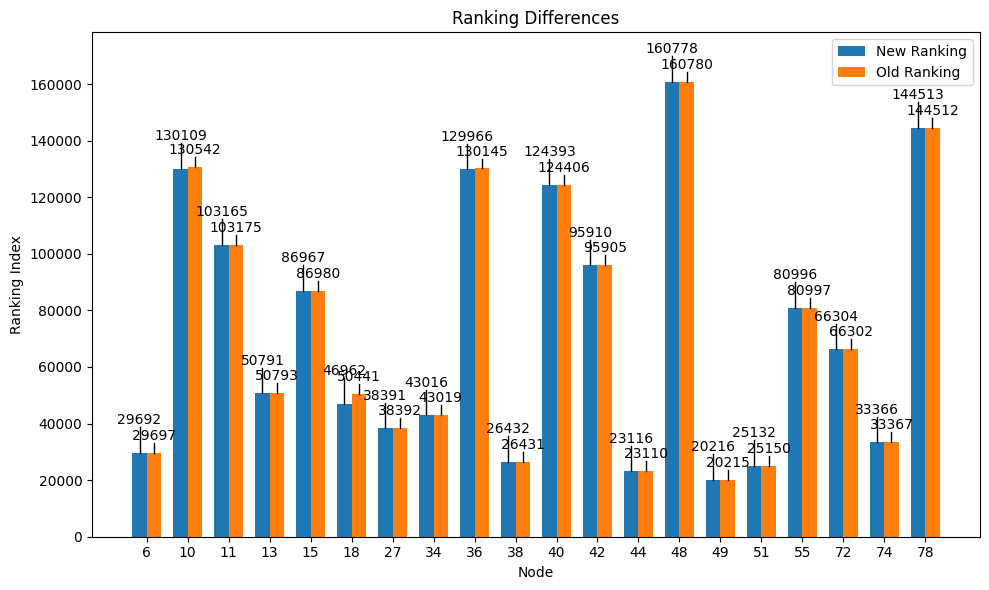

In [ ]:
# @title
# Plot the differences
plot_pagerank_ranking_differences(diff_df_X[:20])

##b) Create another page Y
Unsatisfied with the PageRank of your page X; you create another page Y (with
no in-links) that links to X: What are the PageRanks of all the n + 2 pages
now? Does the PageRank of X improve?

In [ ]:
# @title
# Determine the new index for Y and append it to the data
Y_index = int(data_copy['Node'].max() + 1)
data_copy.loc[len(data_copy)] = [Y_index, X_index, 1.0]

# Generate the updated transition matrix
P_3 = build_transition_matrix(data_copy)


In [ ]:
# @title
data_copy

,Node,Link,Prob
0,1,6548,0.500000
1,1,15409,0.500000
2,2,252915,0.032258
3,2,246897,0.032258
4,2,251658,0.032258
...,...,...,...
2382909,281903,94440,0.142857
2382910,281903,56088,0.142857
2382911,281903,44103,0.142857
2382912,281904,281904,1.000000


In [ ]:
# @title
# Apply the power method to calculate the second iteration results
x_third, iterations_third, error_third, _, _ = power_method(P_3, 0.85, 1e-8, False)

# Sort and get the indices of the top-ranked nodes
sorted_indices = (np.argsort(x_third.flatten()) + 1)[::-1]


Power method converged after 91 iterations (damping factor: 0.85).


In [ ]:
# @title

print(f"Pagerank of X: {np.where(sorted_indices == X_index)[0][0]}.")
print(f"Pagerank of Y: {np.where(sorted_indices == Y_index)[0][0]}.")

Pagerank of X: 16180.
Pagerank of Y: 262924.


##c) Create another third page Z

Still unsatisfied, you create a third page Z: How should you set up the links on
your three pages so as to maximize the PageRank of X?


In [ ]:
# @title
# Copy data and add X
data_copy = data.copy()
X_index = int(data_copy.Node.max()+1)
Y_index = int(data_copy.Node.max()+2)
Z_index = int(data_copy.Node.max()+3)

data_copy.loc[len(data_copy.index)] = [X_index, X_index, 1]
data_copy.loc[len(data_copy.index)] = [Y_index, X_index, 1]
data_copy.loc[len(data_copy.index)] = [Z_index, X_index, 1]

# define new P
P_4= build_transition_matrix(data_copy)

x_4, iterations_4, error_4, _, _= power_method(P_4 , 0.85, 1e-8, False)
sorted_indices_4 = (np.argsort(x_4.flatten())+1)[::-1]

print(f"\nPagerank of X: {np.where(sorted_indices_4 == X_index)[0][0]}.")
print(f"Pagerank of Y: {np.where(sorted_indices_4 == Y_index)[0][0]}.")
print(f"Pagerank of Z: {np.where(sorted_indices_4 == Z_index)[0][0]}.")

Power method converged after 91 iterations (damping factor: 0.85).

Pagerank of X: 11114.
Pagerank of Y: 279491.
Pagerank of Z: 262924.


## d)Add links from X,Y,Z to popular pages

You have one last idea, you add links from your page X to older, popular pages
(e.g.: you add a list of ?Useful links? on your page). Does this improve the
PageRank of X? Does the answer change if you add links from Y or Z to older,
popular pages?


In [ ]:
# @title
# delete existing X node
data_copy.drop(data_copy.loc[data_copy.Node == X_index].index, inplace=True)
data_copy.reset_index(inplace=True, drop=True)

# Add 10 top pages for X
for i in sorted_indices_4[:10]:
    data_copy.loc[len(data_copy.index)] = [X_index, i, 1/10]

# define new P
P_4= build_transition_matrix(data_copy)

x_5, iterations_5, error_5, _, _ = power_method(P_4 , 0.85, 1e-8, False)
sorted_indices_5 = (np.argsort(x_5.flatten())+1)[::-1]

print(f"\nPagerank of X: {np.where(sorted_indices_5 == X_index)[0][0]}.")
print(f"Pagerank of Y: {np.where(sorted_indices_5 == Y_index)[0][0]}.")
print(f"Pagerank of Z: {np.where(sorted_indices_5 == Z_index)[0][0]}.")

Power method converged after 91 iterations (damping factor: 0.85).

Pagerank of X: 109089.
Pagerank of Y: 279491.
Pagerank of Z: 262924.


In [ ]:
# @title
# delete existing X, Y, Z node
data_copy.drop(data_copy.loc[(data_copy.Node == X_index) | (data_copy.Node == Y_index) | (data_copy.Node == Z_index)].index, inplace=True)
data_copy.reset_index(inplace=True, drop=True)

# Add X link
data_copy.loc[len(data_copy.index)] = [X_index, X_index, 1]

# Add X and top 10 pages to Y and Z
data_copy.loc[len(data_copy.index)] = [Y_index, X_index, 1/11]
data_copy.loc[len(data_copy.index)] = [Z_index, X_index, 1/11]

# Add 10 top pages for X
for i in sorted_indices_5[:10]:
    data_copy.loc[len(data_copy.index)] = [Y_index, i, 1/11]
    data_copy.loc[len(data_copy.index)] = [Z_index, i, 1/11]

# define new P
P_5_2= build_transition_matrix(data_copy)

x_2, iter_2, error_2, _, _ = power_method(P_5_2 , 0.85, 1e-8, False)
sorted_indices_5_2 = (np.argsort(x_2.flatten())+1)[::-1]

print(f"\nPagerank of X: {np.where(sorted_indices_5_2 == X_index)[0][0]}.")
print(f"Pagerank of Y: {np.where(sorted_indices_5_2 == Y_index)[0][0]}.")
print(f"Pagerank of Z: {np.where(sorted_indices_5_2 == Z_index)[0][0]:}.")

Power method converged after 91 iterations (damping factor: 0.85).

Pagerank of X: 27084.
Pagerank of Y: 279491.
Pagerank of Z: 262924.


## e) Raise the PageRank of X

Describe what steps you might take to raise the PageRank of X further. You do
not need to prove anything here, just summarize your thoughts based on the
previous parts. For extra credit though, you can prove what the structure for
a link farm with m nodes should be to optimize the PageRank of X

In [ ]:
# @title

# Add X to top page
data_copy.loc[len(data_copy.index)] = [sorted_indices_5_2[0], X_index, 1]
count_top = data_copy.loc[(data_copy.Node == sorted_indices_5_2[0])].shape[0]

# readjust probs
value1 = data_copy.loc[(data_copy.Node == sorted_indices_5_2[0]), 'Prob'] = 1/count_top

In [ ]:
# @title
value1

0.007751937984496124

In [ ]:
# @title
# define new P
P_6= build_transition_matrix(data_copy)

x_2, iter_2, error_2, _, _ = power_method(P_6 , 0.85, 1e-8, False)
top = (np.argsort(x_2.flatten())+1)[::-1]

print(f"\nPagerank of X: {np.where(top == X_index)[0][0]}.")
print(f"Pagerank of Y: {np.where(top == Y_index)[0][0]}.")
print(f"Pagerank of Z: {np.where(top == Z_index)[0][0]}.")

Power method converged after 91 iterations (damping factor: 0.85).

Pagerank of X: 129.
Pagerank of Y: 279491.
Pagerank of Z: 262924.


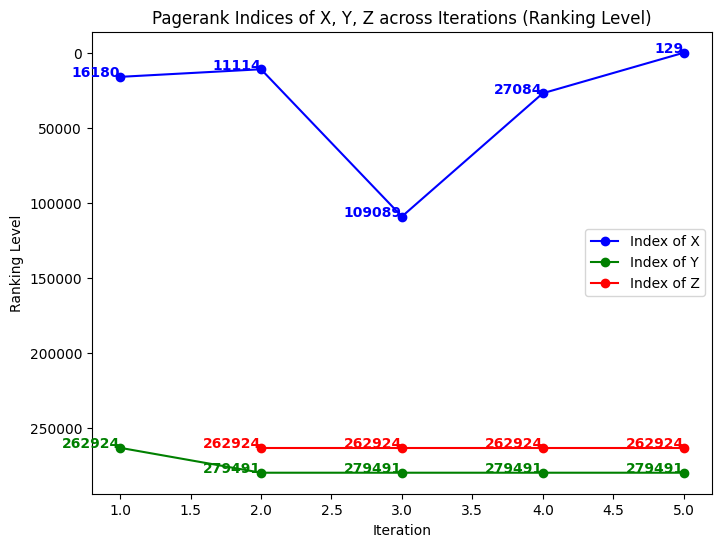

In [ ]:
# @title
import matplotlib.pyplot as plt
import numpy as np


def plot_pagerank_lines(indexes_data):
    """
    Plots a line graph of the indices of X, Y, and Z across different iterations.
    The lower the index, the better the ranking.
    Missing values are marked as gaps.

    Parameters:
    indexes_data (list of tuples): Each tuple contains the indices of X, Y, and Z for each iteration.
    """
    # Initialize lists for X, Y, Z indices
    X_indices, Y_indices, Z_indices = [], [], []

    # Loop over the data to collect indices
    for data in indexes_data:
        X_idx = data[0] if data[0] is not None else None
        Y_idx = data[1] if data[1] is not None else None
        Z_idx = data[2] if data[2] is not None else None

        X_indices.append(X_idx)
        Y_indices.append(Y_idx)
        Z_indices.append(Z_idx)

    # Create the plot
    plt.figure(figsize=(8, 6))

    # Plot the indices for X, Y, Z, with None handling for missing indices
    plt.plot(range(1, len(indexes_data) + 1), X_indices, marker='o', label='Index of X', linestyle='-', color='blue', markersize=6)
    plt.plot(range(1, len(indexes_data) + 1), Y_indices, marker='o', label='Index of Y', linestyle='-', color='green', markersize=6)
    plt.plot(range(1, len(indexes_data) + 1), Z_indices, marker='o', label='Index of Z', linestyle='-', color='red', markersize=6)

    # Add labels to the points
    for i, (X_idx, Y_idx, Z_idx) in enumerate(zip(X_indices, Y_indices, Z_indices)):
        if X_idx is not None:
            plt.text(i+1, X_idx, str(X_idx), fontsize=10,weight='bold',ha='right', color='blue')
        if Y_idx is not None:
            plt.text(i+1, Y_idx, str(Y_idx), fontsize=10,weight='bold', ha='right', color='green')
        if Z_idx is not None:
            plt.text(i+1, Z_idx, str(Z_idx), fontsize=10,weight='bold', ha='right', color='red')

    # Reverse the Y-axis so that lower rankings are at the top
    plt.gca().invert_yaxis()

    # Add titles and labels
    plt.title("Pagerank Indices of X, Y, Z across Iterations (Ranking Level)")
    plt.xlabel("Iteration")
    plt.ylabel("Ranking Level")
    plt.legend()

    # Add grid and show the plot
    plt.show()

# Example usage
# Assuming X_index, Y_index, Z_index are defined and sorted_indices from each iteration are available
indexes_data = [
    (np.where(sorted_indices == X_index)[0][0], np.where(sorted_indices == Y_index)[0][0], _),
    (np.where(sorted_indices_4 == X_index)[0][0], np.where(sorted_indices_4 == Y_index)[0][0], np.where(sorted_indices_4 == Z_index)[0][0]),
    (np.where(sorted_indices_5 == X_index)[0][0], np.where(sorted_indices_5 == Y_index)[0][0], np.where(sorted_indices_5 == Z_index)[0][0]),
    (np.where(sorted_indices_5_2 == X_index)[0][0], np.where(sorted_indices_5_2 == Y_index)[0][0], np.where(sorted_indices_5_2 == Z_index)[0][0]),
    (np.where(top == X_index)[0][0], np.where(top == Y_index)[0][0], np.where(top == Z_index)[0][0]),
]

plot_pagerank_lines(indexes_data)


### Summary of Pagerank Changes for X, Y, Z Across Iterations

- **Initial Values** (Before adding links):
  - **X**: Pagerank of **16180**.
  - **Y**: Pagerank of **262924**.
  - **Z**: No Pagerank for Z initially.

- **After Adding Y**:
  - **X**: Pagerank of **11114**.
  - **Y**: Pagerank of **279491**.
  - **Z**: Pagerank of **262924**.

- **After Adding Z**:
  - **X**: Pagerank of **109089**.
  - **Y**: Pagerank of **279491**.
  - **Z**: Pagerank of **262924** (No change for Z).

- **After Adding Link from X to Popular Pages**:
  - **X**: Pagerank of **27084**.
  - **Y**: Pagerank of **279491**.
  - **Z**: Pagerank of **262924** (No change for Z).

- **After Adding Links from Y, Z to Popular Pages**:
  - **X**: Pagerank of **129** (Significant increase).
  - **Y**: Pagerank of **279491**.
  - **Z**: Pagerank of **262924** (No change for Z).
  
### Conclusion:
- **X** shows a significant increase in Pagerank, especially after adding links from **Y** and **Z** to popular pages. Its Pagerank rises from **16180** to **129**.
- **Y** remains stable at **279491**, and **Z** remains constant at **262924** after its initial addition.
